In [2]:
import torch
from transformers import CLIPProcessor, CLIPModel

In [3]:
import torchvision.transforms.functional as TF,torch.nn.functional as F
from miniai.datasets import *
from datasets import load_dataset,load_dataset_builder

In [4]:
"GPU is there" if torch.cuda.is_available() else Exception("GPU is missing") 

'GPU is there'

In [5]:
model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to("cuda")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)

Optional: Check if Container is paging

apt update && apt-get install sysstat && pidstat -r -d --human 3

# CIFAR10 example

In [6]:
xl,yl = 'img','label'
name = "cifar10"
dsdc = load_dataset(name)
dsdc

DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 10000
    })
})

In [7]:
x1c = dsdc['train'][xl][0]
type(x1c)

PIL.PngImagePlugin.PngImageFile

In [8]:
TF.to_tensor(x1c).min(), TF.to_tensor(x1c).max()

(tensor(0.1333), tensor(0.7961))

# Loading Tiny-Imagenet

In [37]:
xl,yl = 'image','label'
name = "zh-plus/tiny-imagenet"
dsd = load_dataset(name)

In [38]:
dsd

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 100000
    })
    valid: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [39]:
xb1 = dsd['train'][xl][0]
type(xb1)

PIL.JpegImagePlugin.JpegImageFile

In [40]:
TF.to_tensor(xb1).size()

torch.Size([3, 64, 64])

In [41]:
TF.to_tensor(xb1).min(), TF.to_tensor(xb1).max()

(tensor(0.0078), tensor(1.))

In [42]:
@inplace
def transformi(b): b[xl] = [TF.to_tensor(o)-0.0 for o in b[xl]]

bs = 32
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=7)

In [43]:
dt = dls.train
xb,yb = next(iter(dt))

In [44]:
xb[0].shape

torch.Size([3, 64, 64])

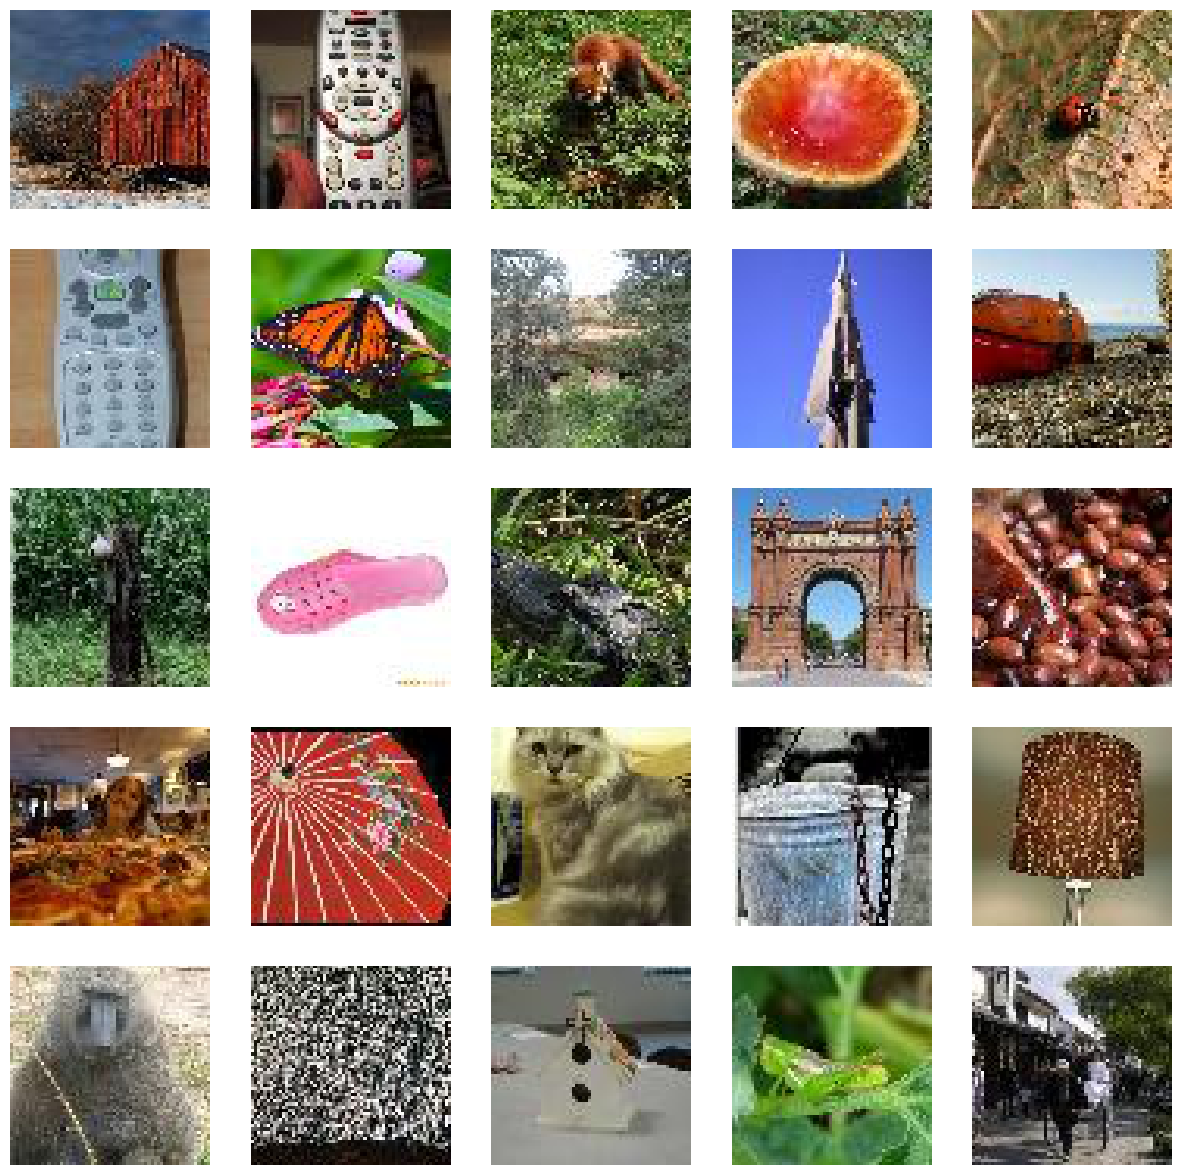

In [45]:
show_images(xb[:25]+0.0)

In [46]:
yb

tensor([ 60, 130,  53, 195,  33, 130,  39,  83, 127, 107,  70, 133,   4, 154,
        164, 181, 157,  28,  73, 105,  51, 151,  70,  34, 103,  74, 159,  37,
         28,  16, 122,  19])

In [123]:
from huggingface_hub import hf_hub_download
fp_json_lbl_to_classtxt = hf_hub_download(repo_id=name, filename="dataset_infos.json", repo_type="dataset")
fp_classtxt_to_humantxt = hf_hub_download(repo_id=name, filename="classes.py", repo_type="dataset")

In [124]:
import json 
   
f = open(fp_json_lbl_to_classtxt,) 
data_l_to_c = json.load(f) 
f.close() 

In [125]:
pos2idx = classtxt = data_l_to_c['Maysee--tiny-imagenet']['features']['label']['names']

In [126]:
pos2idx[0:8]

['n01443537',
 'n01629819',
 'n01641577',
 'n01644900',
 'n01698640',
 'n01742172',
 'n01768244',
 'n01770393']

In [127]:
#idx2pos = {v:k for k,v in enumerate(pos2idx)}

In [128]:
#list(idx2pos.items())[:8]

In [129]:
# Repo provided a variable called 'i2d'
exec(open(fp_classtxt_to_humantxt).read()) 
# Let's rename this variable to something suitable for this notebook
idx2human = i2d

In [133]:
list(idx2human.items())[:8]

[('n00001740', 'entity'),
 ('n00001930', 'physical entity'),
 ('n00002137', 'abstraction, abstract entity'),
 ('n00002452', 'thing'),
 ('n00002684', 'object, physical object'),
 ('n00003553', 'whole, unit'),
 ('n00003993', 'congener'),
 ('n00004258', 'living thing, animate thing')]

<Axes: >

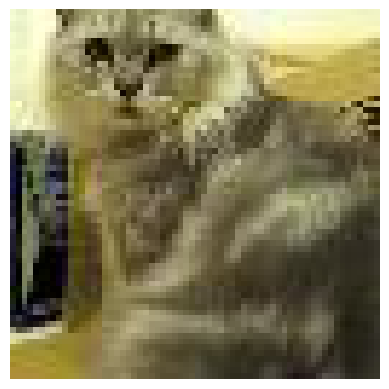

In [130]:
show_image(xb[17])

In [131]:
pos2idx[yb[17]]

'n02123394'

In [132]:
idx2human[pos2idx[yb[17]]]

'Persian cat'

### Step 1: Installation
First, ensure you have the required libraries installed:
```bash
pip install transformers
pip install torch
pip install torchvision
pip install Pillow  # For image processing
```

### Step 2: Load the CLIP Model and Preprocessing Tools
Load the CLIP model and preprocess your image and text data using the Hugging Face library.
```python
import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel

# Load the CLIP model and processor
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
```

### Step 3: Prepare the Image and Text Data
Preprocess the image and tokenize the text descriptions.
```python
# Load and preprocess the image
image_path = "path/to/your/image.jpg"
image = Image.open(image_path)

# Define the text descriptions
texts = ["a description", "another description", "yet another description"]

# Preprocess the image and texts
inputs = processor(text=texts, images=image, return_tensors="pt", padding=True)
image_input = inputs["pixel_values"].to(device)
text_inputs = inputs["input_ids"].to(device)
attention_mask = inputs["attention_mask"].to(device)
```

### Step 4: Compute Features
Generate image and text embeddings using the CLIP model.
```python
with torch.no_grad():
    # Compute the image and text embeddings
    image_features = model.get_image_features(image_input)
    text_features = model.get_text_features(input_ids=text_inputs, attention_mask=attention_mask)

# Normalize the features
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
```

### Step 5: Compute Similarity and Get Results
Calculate the similarity scores between the image and each text description, and identify the best match.
```python
# Compute similarity scores
similarity_scores = image_features @ text_features.T

# Get the index of the best matching text description
best_match_index = similarity_scores.argmax().item()

# Output the best matching text description
print(f"Best match: {texts[best_match_index]} (score: {similarity_scores[0, best_match_index]:.4f})")
```